# AFM Digital Twin: Image Reconstruction with Sparse Scanning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/AFM/3_AFM_Sparse_Scanning_COLAB_Hackaton.ipynb)

To reduce the time taken to acquire an image in AFM, it is preferable to not scan in a raster fashion but rather along a different trajectory, to acquire a subset of the pixels. This presents a problem of image reconstruction, because the sparse measurements need to be used to 'fill in' the missing pixels in the image.

## Task Overview

Participants are challenged to develop techniques for reconstructing images from **sparse scanning** data acquired using non-traditional trajectories, such as spirals or arcs.

---

### **Key Questions**

> **Can we effectively reconstruct a complete AFM image from a subset of acquired pixels?**


# 1. Run server

In [1]:
!pip install pyro5
!pip install scifireaders
!pip install sidpy
!pip install pynsid
!pip install git+https://github.com/pycroscopy/DTMicroscope.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 34.1 MB/s eta 0:00:00
  Cloning https://github.com/pycroscopy/DTMicroscope.git to /tmp/pip-req-build-a9q51w6o
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/DTMicroscope.git /tmp/pip-req-build-a9q51w6o
  Resolved https://github.com/pycroscopy/DTMicroscope.git to commit 352d02f4

In [2]:
!run_server_afm

Server started and running in the background. Logs are being written to server.log.


# 2. Client side

In [3]:
import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
from IPython.display import clear_output, display

## 2.1 Get data

In [4]:
!wget https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5

--2025-12-11 20:03:47--  https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5 [following]
--2025-12-11 20:03:49--  https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22317256 (21M) [application/octet-stream]
Saving to: ‘dset_spm1.h5’

dset_spm1.h5        100%[===================>]  21.28M   132MB/s    in 0.2s    

2025-12-11 20:0

## 2.2 Register Data to the Digital twin

In [5]:
uri = "PYRO:microscope.server@localhost:9092" #port for the AFM DT 9092
mic_server = Pyro5.api.Proxy(uri)
import sys

if 'google.colab' in sys.modules:
    mic_server.initialize_microscope("AFM", data_path = r"dset_spm1.h5")
else:
    mic_server.initialize_microscope("AFM", data_path = "../test/datasets/dset_spm1.h5")
mic_server.setup_microscope(data_source = 'Compound_Dataset_1')#upload dataset?
mic_server.get_dataset_info()

[('channels',
  ['Channel_000',
   'Channel_001',
   'Channel_002',
   'Channel_003',
   'Channel_004',
   'Channel_005',
   'Channel_006']),
 ('signals',
  ['HeightRetrace',
   'Amplitude1Retrace',
   'Amplitude2Retrace',
   'Phase1Retrace',
   'Phase2Retrace',
   'FrequencyRetrace',
   'Response']),
 ('units', ['m', 'm', 'm', 'deg', 'deg', 'm', 'a.u.']),
 ('scans', [0, 1, 2, 3, 4, 5]),
 ('spectra', []),
 ('point_clouds', [6])]

## Reconstruction from the sparce image

Text(0.5, 1.0, 'Phase')

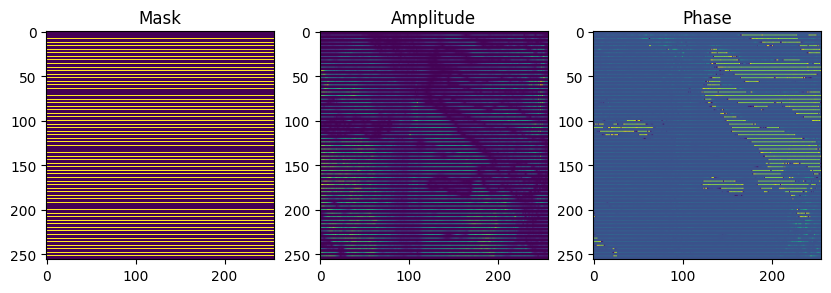

In [7]:
#Let's do the simplest thing to speed up scanning: just start skipping lines.

y_coords = np.linspace(mic_server.y_min, mic_server.y_max, 256)
new_image = np.zeros(shape=(256, 256,2))
mask = np.zeros(new_image.shape[:2])

for ind,coord in enumerate(y_coords):
    #Scan every 4th line
    if ind%4==0:
        line = mic_server.scan_individual_line('horizontal', coord = float(coord), channels=['Amplitude1Retrace', 'Phase1Retrace'])
        new_image[ind,:,0] = line[0][0]
        new_image[ind,:,1] = line[0][1]
        mask[ind,:]=1

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
axes[0].imshow(mask, interpolation = 'None')
axes[0].set_title('Mask')
axes[1].imshow(new_image[:,:,0])
axes[2].imshow(new_image[:,:,1])
axes[1].set_title('Amplitude')
axes[2].set_title('Phase')

### Biharmonic inpainting

Text(0.5, 1.0, 'Phase, MAE:57.29')

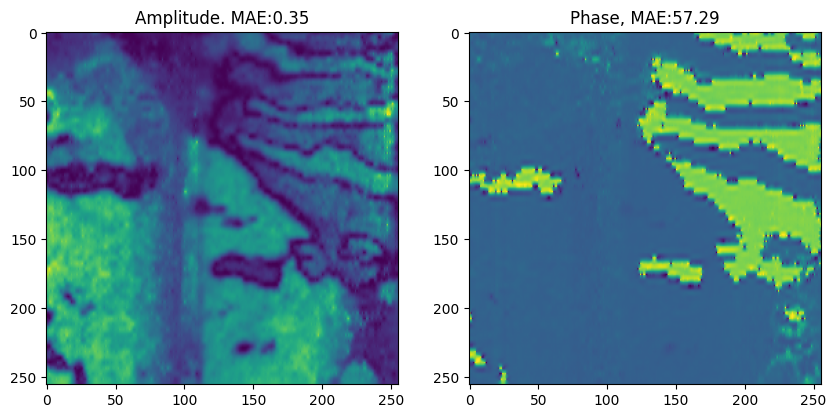

In [8]:
#A simple reconstruction algorithm is biharmonic inpainting. Let's try it

from skimage.restoration import inpaint
from sklearn.metrics import mean_absolute_error

inverted_mask = np.full(mask.shape, 1)
inverted_mask[mask==1]=0

sparse_image = new_image[:,:,0]
sparse_image_norm = (sparse_image - sparse_image.min()) / (sparse_image.max() - sparse_image.min())
inpainted_image_amp = inpaint.inpaint_biharmonic(sparse_image_norm, inverted_mask)

sparse_image = new_image[:,:,1]
sparse_image_norm = (sparse_image - sparse_image.min()) / (sparse_image.max() - sparse_image.min())
inpainted_image_phase = inpaint.inpaint_biharmonic(sparse_image_norm, inverted_mask)

#compare to the ground truth to calculate error
array_list, shape, dtype =  mic_server.get_scan(channels=['Amplitude1Retrace',])
amp_data_gt =  np.array(array_list, dtype=dtype).reshape(shape)[0,:,:]

array_list, shape, dtype =  mic_server.get_scan(channels=['Phase1Retrace',])
phase_data_gt =  np.array(array_list, dtype=dtype).reshape(shape)[0,:,:]

mae_amp = mean_absolute_error(amp_data_gt, inpainted_image_amp)
mae_phase = mean_absolute_error(phase_data_gt, inpainted_image_phase)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].imshow(inpainted_image_amp)
axes[1].imshow(inpainted_image_phase)
axes[0].set_title('Amplitude. MAE:{:.2f}'.format(mae_amp))
axes[1].set_title('Phase, MAE:{:.2f}'.format(mae_phase))